In [9]:
# Import necessary libraries
using Catlab, Catlab.Programs, Catlab.Doctrines, 
      Catlab.WiringDiagrams;

using AlgebraicRelations.QueryLib, AlgebraicRelations.SQL;

## Define the Schema
We need to define the data types, the table column names, and the syntax of our schema

In [13]:
# Data Types
types  = Dict(:full_name => (["first", "last"],[String,String]),
              :person    => (["id"], [Int]),
              :X         => ([], [Int]),
              :F         => ([], [Float64]),
              :ID        => (["id"], [Int]))

# Tables -> Column names
tables = Dict(:names     => (["person"], ["full_name"]),
              :employees => (["person"],["ID"]),
              :customers => (["person"],["ID"]),
              :manager   => (["person"],["manager"]),
              :salary    => (["person"],["salary"]))

# Define Type Syntax
full_name = Ob(FreeBicategoryRelations, :full_name);
person = Ob(FreeBicategoryRelations, :person);
X = Ob(FreeBicategoryRelations, :X);
F = Ob(FreeBicategoryRelations, :F);
ID = Ob(FreeBicategoryRelations, :ID);

# Define Table Syntax
names = Hom(:names, person, full_name);
employees = Hom(:employees, person, ID);
customers = Hom(:customers, person, ID);
manager = Hom(:manager, person, person);
salary = Hom(:salary, person, F);

syn_types  = [full_name, person, X, F, ID];
syn_tables = [names, employees, customers, manager, salary];

## Generate the Query
There are two methods of generating queries at the moment. 

The first is to write out an algebraic formula from the `Ob`s and `Hom`s just defined.

The second is to define a program using the current tables and objects as functions and types respectively.

SELECT t3.person, t4.full_name, t5.salary, t6.manager
FROM manager AS t3, names AS t4, salary AS t5, manager AS t6
WHERE t3.manager=t4.person AND t3.manager=t5.person AND t3.manager=t6.person;


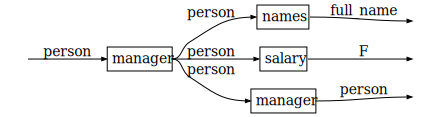

In [14]:
# Algebraic Formula Method

formula = manager⋅mcopy(person)⋅((mcopy(person)⋅(names⊗salary))⊗manager)
q = Query(tables, formula)

println(sql(q))
draw_query(q)

SELECT t3.person, t4.full_name, t5.salary, t6.manager
FROM manager AS t3, names AS t4, salary AS t5, manager AS t6
WHERE t3.manager=t4.person AND t3.manager=t5.person AND t3.manager=t6.person;


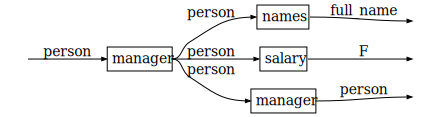

In [15]:
# Program Method

schema = to_presentation(syn_types, syn_tables)

f = @program schema (p::person) begin
  m = manager(p)
  return names(m), salary(m), manager(m)
end
q = Query(tables, f)

println(sql(q))
draw_query(q)